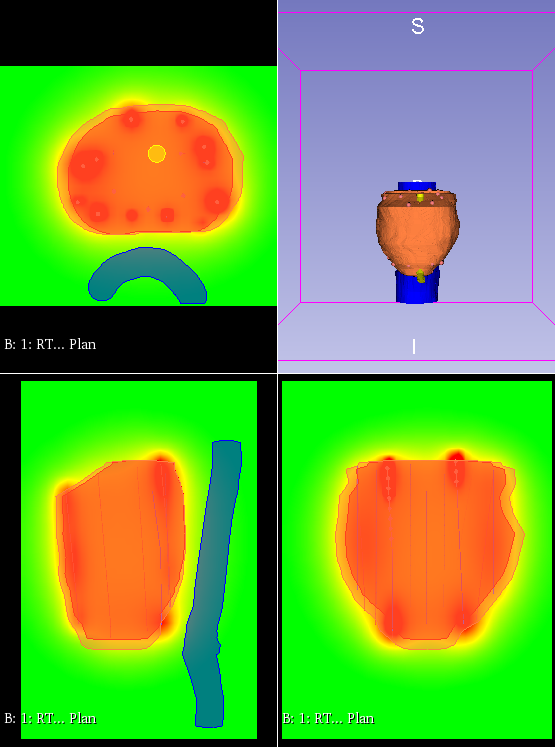

In [15]:
from DICOMLib import DICOMUtils
import vtkSegmentationCorePython as vtkSegmentationCore

# Clear scene
slicer.mrmlScene.Clear(False)


# Code from https://github.com/SlicerRt/SlicerRT/blob/master/BatchProcessing/BatchStructureSetConversion.py
def ConvertStructureSetToLabelmap():
    # ConvertStructureSetToLabelmap()
    labelmapsToSave = []

    # Get all segmentation nodes from the scene
    segmentationNodes = slicer.util.getNodes('vtkMRMLSegmentationNode*')

    for segmentationNode in segmentationNodes.values():
        # Set referenced volume as rasterization reference
        referenceVolume = slicer.vtkSlicerDicomRtImportExportModuleLogic.GetReferencedVolumeByDicomForSegmentation(
            segmentationNode)
        if referenceVolume == None:
            continue

    # Perform conversion
    binaryLabelmapRepresentationName = vtkSegmentationCore.vtkSegmentationConverter.GetSegmentationBinaryLabelmapRepresentationName()
    segmentation = segmentationNode.GetSegmentation()
    segmentation.CreateRepresentation(binaryLabelmapRepresentationName)

    # Create labelmap volume nodes from binary labelmaps
    segmentIDs = vtk.vtkStringArray()
    segmentation.GetSegmentIDs(segmentIDs)
    for segmentIndex in range(0, segmentIDs.GetNumberOfValues()):
        segmentID = segmentIDs.GetValue(segmentIndex)
        segment = segmentation.GetSegment(segmentID)
        binaryLabelmap = segment.GetRepresentation(
            vtkSegmentationCore.vtkSegmentationConverter.GetSegmentationBinaryLabelmapRepresentationName())
        if not binaryLabelmap:
            continue
        labelmapNode = slicer.vtkMRMLLabelMapVolumeNode()
        slicer.mrmlScene.AddNode(labelmapNode)
        labelmapName = segmentationNode.GetName() + "_" + segmentID
        labelmapNode.SetName(labelmapName)
        if not slicer.vtkSlicerSegmentationsModuleLogic.CreateLabelmapVolumeFromOrientedImageData(
          binaryLabelmap, labelmapNode):
            continue

        # Append volume to list
        labelmapsToSave.append(labelmapNode)# SaveLabelmaps into output_dir

    return labelmapsToSave


def SaveLabelmaps(labelmapsToSave, outputDir):
    for labelmapNode in labelmapsToSave:
        # Clean up file name and set path
        fileName = labelmapNode.GetName() + '.nrrd'
        table = str.maketrans(dict.fromkeys('!?:;'))
        fileName = fileName.translate(table)
        filePath = outputDir + '/' + fileName
        logging.info('  Saving structure ' + labelmapNode.GetName() + '\n    to file ' + fileName)

    # Save to file
    success = slicer.util.saveNode(labelmapNode, filePath)
    if not success:
        logging.error('Failed to save labelmap: ' + filePath)

    
# Load dicom
DICOMUtils.openTemporaryDatabase()
DICOMUtils.importDicom('downloads/Brachy patients/PYPB01')

#Load first patient into slicer
patient = slicer.dicomDatabase.patients()[0]
DICOMUtils.loadPatientByUID(patient)

output_dir = slicer.app.temporaryPath + '/BrachyPatients/Output'
labelmaps = ConvertStructureSetToLabelmap()
SaveLabelmaps(labelmaps, output_dir)
    
display()

In [16]:
# Get first plan node
planNodes = slicer.util.getNodes('vtkMRMLRTPlanNode*')
planNode = list(planNodes.values())[0]
# Get ultrasound volume node
ultrasoundNodes = slicer.util.getNodes('vtkMRMLScalarVolumeNode*')
ultrasoundNode = list(ultrasoundNodes.values())[0]

print(planNode)
print(ultrasoundNode)

vtkMRMLRTPlanNode (000002374160A290)
  ID: vtkMRMLRTPlanNode1
  ClassName: vtkMRMLRTPlanNode
  Name: 1: RTPLAN: Onc Brachy Plan (Oncentra Prostate Treatment Plan (LIVE))
  Debug: false
  MTime: 9907823
  Description: (none)
  SingletonTag: (none)
  HideFromEditors: false
  Selectable: true
  Selected: false
  UndoEnabled: false
  Node references:
    posMarkupsRef: (none)
   TargetSegmentID:   nullptr
   DoseEngineName:   nullptr
   NextBeamNumber:   1
   RxDose:   1
   IsocenterSpecification:   0


vtkMRMLScalarVolumeNode (00000237475131D0)
  ID: vtkMRMLScalarVolumeNode1
  ClassName: vtkMRMLScalarVolumeNode
  Name: 1: Oncentra Prostate Image Series
  Debug: false
  MTime: 9864261
  Description: (none)
  SingletonTag: (none)
  HideFromEditors: false
  Selectable: true
  Selected: false
  UndoEnabled: false
  Attributes:
    DICOM.instanceUIDs:1.3.6.1.4.1.5962.99.1.1207914011.62623561.1560281075227.112.0 1.3.6.1.4.1.5962.99.1.1207914011.62623561.1560281075227.111.0 1.3.6.1.4.1.5962.99.1

In [17]:
# Get catheter nodes (children of plan in SH)
shNode = slicer.vtkMRMLSubjectHierarchyNode.GetSubjectHierarchyNode(slicer.mrmlScene)
planItemID = shNode.GetItemByDataNode(planNode)
children = vtk.vtkIdList()
shNode.GetItemChildren(planItemID, children)

catheterNodes = []
for i in range(children.GetNumberOfIds()):
    child = children.GetId(i)
    catheterNode = shNode.GetItemDataNode(child)
    catheterNodes.append(catheterNode)

print(catheterNodes)

[(vtkSlicerMarkupsModuleMRMLPython.vtkMRMLMarkupsCurveNode)000002373776FD08, (vtkSlicerMarkupsModuleMRMLPython.vtkMRMLMarkupsCurveNode)000002373776FDC8, (vtkSlicerMarkupsModuleMRMLPython.vtkMRMLMarkupsCurveNode)000002373776FE28, (vtkSlicerMarkupsModuleMRMLPython.vtkMRMLMarkupsCurveNode)000002373776FB28, (vtkSlicerMarkupsModuleMRMLPython.vtkMRMLMarkupsCurveNode)000002373776F888, (vtkSlicerMarkupsModuleMRMLPython.vtkMRMLMarkupsCurveNode)000002373776FFA8, (vtkSlicerMarkupsModuleMRMLPython.vtkMRMLMarkupsCurveNode)000002373776FC48, (vtkSlicerMarkupsModuleMRMLPython.vtkMRMLMarkupsCurveNode)000002373776FF48, (vtkSlicerMarkupsModuleMRMLPython.vtkMRMLMarkupsCurveNode)000002373776FCA8, (vtkSlicerMarkupsModuleMRMLPython.vtkMRMLMarkupsCurveNode)000002373776FEE8, (vtkSlicerMarkupsModuleMRMLPython.vtkMRMLMarkupsCurveNode)000002373776FB88, (vtkSlicerMarkupsModuleMRMLPython.vtkMRMLMarkupsCurveNode)000002373A40D1C8, (vtkSlicerMarkupsModuleMRMLPython.vtkMRMLMarkupsCurveNode)000002373A40DCA8, (vtkSlicerM

In [18]:
# Convert each catheter node into labelmap nodes
modelNodes = []
for catheterNode in catheterNodes:
    # 1. Get model from catheter markups curve
    catheterNode.SetCurveTypeToLinear()
    polydata = catheterNode.GetCurveWorld()
    # add catheter diameter
    polydataTube = vtk.vtkTubeFilter()
    polydataTube.SetInputData(polydata)
    polydataTube.SetNumberOfSides(20)
    # 5F catheter radius
    polydataTube.SetRadius(0.7366)
    polydataTube.Update()
    # show on slicer for visualizing purposes
    modelNode = slicer.vtkMRMLModelNode()
    slicer.mrmlScene.AddNode(modelNode)
    modelNode.SetAndObservePolyData(polydataTube.GetOutput())
    # modelNode.CreateDefaultDisplayNodes()
    modelNodes.append(modelNode)

#Create segmentation node
segmentationNode = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLSegmentationNode')
# Convert all model nodes to segments
for modelNode in modelNodes:
    modelSegment = slicer.vtkSlicerSegmentationsModuleLogic().CreateSegmentFromModelNode(modelNode)
    segmentationNode.GetSegmentation().AddSegment(modelSegment)

# Display segmentation node 
slicer.mrmlScene.AddNode(segmentationNode)
segmentationNode.CreateDefaultDisplayNodes()

In [19]:
# Create LabelMapVolumeNode for all segments
labelmapVolumeNode = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLLabelMapVolumeNode')
# Export multiple segments to label map volume node
slicer.modules.segmentations.logic().ExportVisibleSegmentsToLabelmapNode(segmentationNode, labelmapVolumeNode, ultrasoundNode)

# Export to numpy array
numpyArray = arrayFromVolume(labelmapVolumeNode)

print(numpyArray)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
